In [116]:
import sys
sys.path.append('/home/jovyan/workspace')

In [117]:
# %%sh
# rm -rf '../data/test'

In [118]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

In [119]:
system = planetengine.systems.arrhenius.build(res = 32)
initials = {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)}
planetengine.initials.apply(
    initials,
    system,
    )
system.solve()

In [120]:
variable1 = pfn.convert(system.velocityField, 'velocity')
variable2 = pfn.convert(system.temperatureField, 'temperature')
constant = pfn.convert(2.)
shape = pfn.convert(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))
vanilla = pfn.convert(system.viscosityFn, 'viscosity')

In [132]:
def makevar():
    var = variable1
    var = pfn.Region(var, shape)
    var = pfn.Component.rad(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Normalise(var, [0., 1.])
    var = pfn.Quantiles.median(var)
    var = pfn.Filter(var, 1.)
    var = pfn.Gradient.rad(var)
    var = pfn.Binarise(var)
    var = var * vanilla
    var = var ** constant
    var = var * variable2
    var = pfn.Projection(var)
    var = pfn.HandleNaN.zero(var)
    return var

In [133]:
print(round(timeit(makevar, number = 1), 3))

2.867


In [134]:
var = makevar()

Fitted 1 variables to the figure.
HandleNaN{Projection{Operation_uwop=multiply{Operation_uwop=pow{Operation_uwop=multiply{Binarise{Component_component=rad{Gradient{Projection{Filter{Quantiles_ntiles=2{Normalise{Component_component=mag{Gradient{Projection{Component_component=rad{Region{Variable_varName=velocity{};Shape_varName=anon{}}}}}};Constant_val=arr{[ 0.  1.]}{}}};Constant_val=arr{[ 1.]}{}}}}}};Vanilla_varName=viscosity{Variable_varName=temperature{}}};Constant_val=arr{[ 2.]}{}};Variable_varName=temperature{}}};Constant_val=arr{[ 0.]}{}}



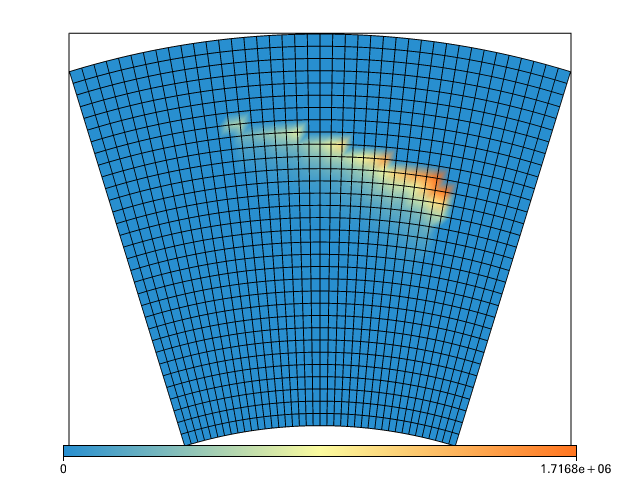

In [135]:
planetengine.quickShow(var.mesh, var)

In [172]:
def testfn(var, timings = '', layer = 1):
    def outer_timefn(var, timinglist = []):
        planetengine.initials.apply(
            initials,
            system,
            )
        var.update()
        system.iterate()
        timing = timeit(var.update, number = 1)
        timinglist.append(timing)
        return timinglist
    var_timings = []
    for i in range(10):
        var_timings = outer_timefn(var, var_timings)
    var_timing = sum(var_timings) / len(var_timings)
    var_timing = round(var_timing, 6)
    timings += '\n'
    newrow = ''
    newrow += layer * '-' + ' '
    newrow += var.opTag
    newrow += ': '
    newrow += '.' * (56 - len(newrow)) + ' '
    newrow += str(var_timing)
    timings += newrow
    for inVar in var.inVars:
        timings = testfn(inVar, timings, layer + 1)
    return timings

In [173]:
timings = testfn(var)

In [174]:
print(timings)


- HandleNaN: ........................................... 0.092444
-- Projection: ......................................... 0.086867
--- Operation_uwop=multiply: ........................... 0.009566
---- Operation_uwop=pow: ............................... 0.00854
----- Operation_uwop=multiply: ......................... 0.005707
------ Binarise: ....................................... 0.001302
------- Component_component=rad: ....................... 0.002464
-------- Gradient: ..................................... 0.002949
--------- Projection: .................................. 0.0019
---------- Filter: ..................................... 0.001455
----------- Quantiles_ntiles=2: ........................ 0.002214
------------ Normalise: ................................ 0.001532
------------- Component_component=mag: ................. 0.001072
-------------- Gradient: ............................... 0.001393
--------------- Projection: ............................ 0.001404
------------

In [38]:
red = pfn.Integral(var)

In [39]:
planetengine.initials.apply(
    initials,
    system,
    )
red.update()
system.iterate()
print(red.evaluate())
print(red.evaluate())
system.iterate()
print(red.evaluate())
print(red.evaluate())

[[ 0.13343348]]
[[ 0.13343348]]
[[ 0.12520339]]
[[ 0.12520339]]


In [40]:
def testfn():
    freshsteps = []
    stalesteps = []
    for i in range(3):
        planetengine.initials.apply(
            initials,
            system,
            )
        red.update
        system.iterate()
        freshsteps.append(timeit(red.update, number = 1))
    for i in range(3):
        stalesteps.append(timeit(red.update, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 5)
    average_stale = round(sum(stalesteps) / len(stalesteps), 5)
    ratio = round(average_fresh / average_stale, 5)
    return(average_fresh, average_stale, ratio)
print(testfn())

(0.04053, 0.0007, 57.9)


0.022955599997658283
Fitted 1 variables to the figure.
Projection{Variable_varName=temperature{}}



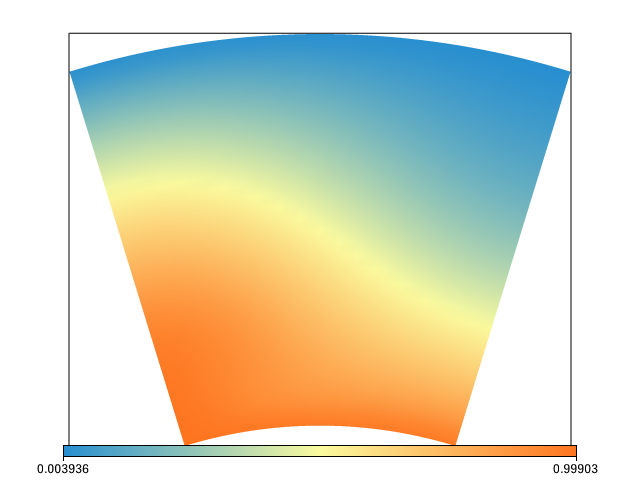

In [210]:
var = pfn.Projection(variable2)
system.iterate()
print(timeit(var.update, number = 1))
planetengine.quickShow(var)

0.022278800002823118
Fitted 1 variables to the figure.
Variable_varName=anon{}



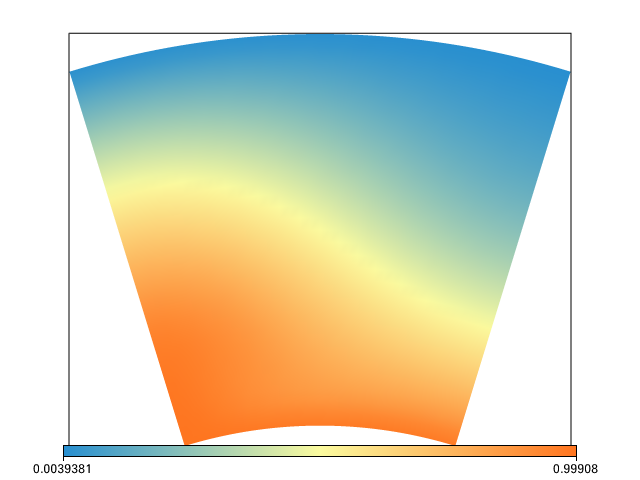

In [211]:
import underworld as uw
projVar = uw.mesh.MeshVariable(
    system.mesh,
    1,
    )
projector = uw.utils.MeshVariable_Projection(
    projVar,
    system.temperatureField,
    )
system.iterate()
print(timeit(projector.solve, number = 1))
planetengine.quickShow(projVar)

0.029738899997028057
Fitted 1 variables to the figure.
Projection{Gradient{Variable_varName=temperature{}}}



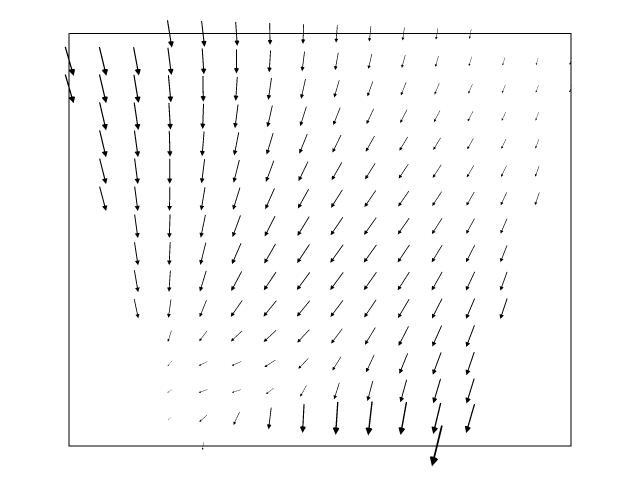

In [212]:
var = pfn.Projection(pfn.Gradient(variable2))
system.iterate()
print(timeit(var.update, number = 1))
planetengine.quickShow(var)

0.026066500002343673
Fitted 1 variables to the figure.
Variable_varName=anon{}



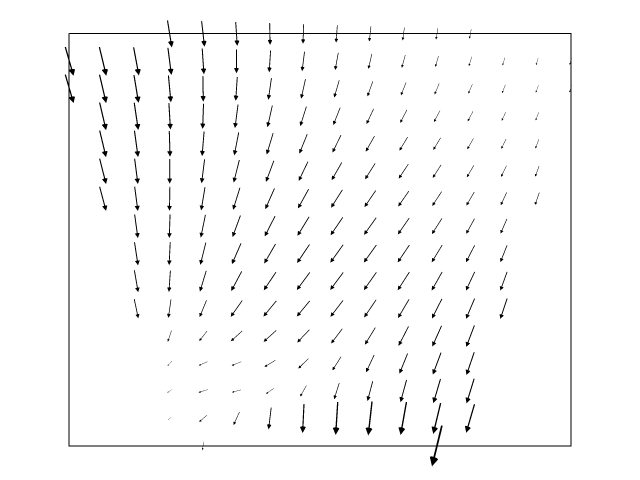

In [214]:
import underworld as uw
projVar = uw.mesh.MeshVariable(
    system.mesh,
    2,
    )
projector = uw.utils.MeshVariable_Projection(
    projVar,
    system.temperatureField.fn_gradient,
    )
system.iterate()
print(timeit(projector.solve, number = 1))
planetengine.quickShow(projVar)